In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Labelling/train_data.csv")

# Count the number of rows for each unique value in the 'sub_category' column
sub_category_counts = df['sub_category'].value_counts()

# Display the result
print(sub_category_counts)

sub_category
men's sports shoes          10137
Shirts                       9828
Speakers                     5472
Refrigerators                1190
Backpacks                    1152
Kids' Watches                 960
Washing Machines              883
Sunglasses                    768
Badminton                     691
Televisions                   672
Suitcases & Trolley Bags      652
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Labelling/train_data.csv")

# Set the target number of images per sub_category
target_count = 652

# Create a balanced dataframe by sampling from each sub_category
balanced_df = df.groupby('sub_category', group_keys=False).apply(lambda x: x.sample(n=target_count, replace=len(x) < target_count))

# Reset index and save to a new CSV if needed
balanced_df = balanced_df.reset_index(drop=True)
balanced_df.to_csv("balanced_dataset.csv", index=False)

print("Balanced dataset created with", target_count, "images per sub_category.")


Balanced dataset created with 652 images per sub_category.


<ipython-input-4-860c5cdfa553>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('sub_category', group_keys=False).apply(lambda x: x.sample(n=target_count, replace=len(x) < target_count))


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Labelling/test_data.csv")

# Count the number of rows for each unique value in the 'sub_category' column
sub_category_counts = df['sub_category'].value_counts()

# Display the result
print(sub_category_counts)

sub_category
men's sports shoes          2535
Shirts                      2457
Speakers                    1368
Refrigerators                298
Backpacks                    288
Kids' Watches                240
Washing Machines             221
Sunglasses                   192
Badminton                    173
Televisions                  168
Suitcases & Trolley Bags     164
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Labelling/test_data.csv")

# Set the target number of images per sub_category
target_count = 164

# Create a balanced dataframe by sampling from each sub_category
balanced_df = df.groupby('sub_category', group_keys=False).apply(lambda x: x.sample(n=target_count, replace=len(x) < target_count))

# Reset index and save to a new CSV if needed
balanced_df = balanced_df.reset_index(drop=True)
balanced_df.to_csv("balanced_test_dataset.csv", index=False)

print("Balanced dataset created with", target_count, "images per sub_category.")

Balanced dataset created with 164 images per sub_category.


<ipython-input-9-54ba885e7370>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('sub_category', group_keys=False).apply(lambda x: x.sample(n=target_count, replace=len(x) < target_count))


Saved best model with validation loss: 0.9622
Epoch [1/10], Train Loss: 1.3991, Train Acc: 55.65%, Val Loss: 0.9622, Val Acc: 69.57%
Saved best model with validation loss: 0.8327
Epoch [2/10], Train Loss: 0.8994, Train Acc: 72.02%, Val Loss: 0.8327, Val Acc: 74.78%
Saved best model with validation loss: 0.7352
Epoch [3/10], Train Loss: 0.7407, Train Acc: 76.46%, Val Loss: 0.7352, Val Acc: 77.94%
Saved best model with validation loss: 0.7265
Epoch [4/10], Train Loss: 0.6171, Train Acc: 79.74%, Val Loss: 0.7265, Val Acc: 78.66%
Saved best model with validation loss: 0.7020
Epoch [5/10], Train Loss: 0.5283, Train Acc: 82.84%, Val Loss: 0.7020, Val Acc: 80.04%
Epoch [6/10], Train Loss: 0.4556, Train Acc: 84.79%, Val Loss: 0.7073, Val Acc: 80.82%
Epoch [7/10], Train Loss: 0.3899, Train Acc: 87.12%, Val Loss: 0.7330, Val Acc: 81.21%
Epoch [8/10], Train Loss: 0.3358, Train Acc: 88.46%, Val Loss: 0.7326, Val Acc: 81.26%
Epoch [9/10], Train Loss: 0.2830, Train Acc: 90.66%, Val Loss: 0.7735, Val

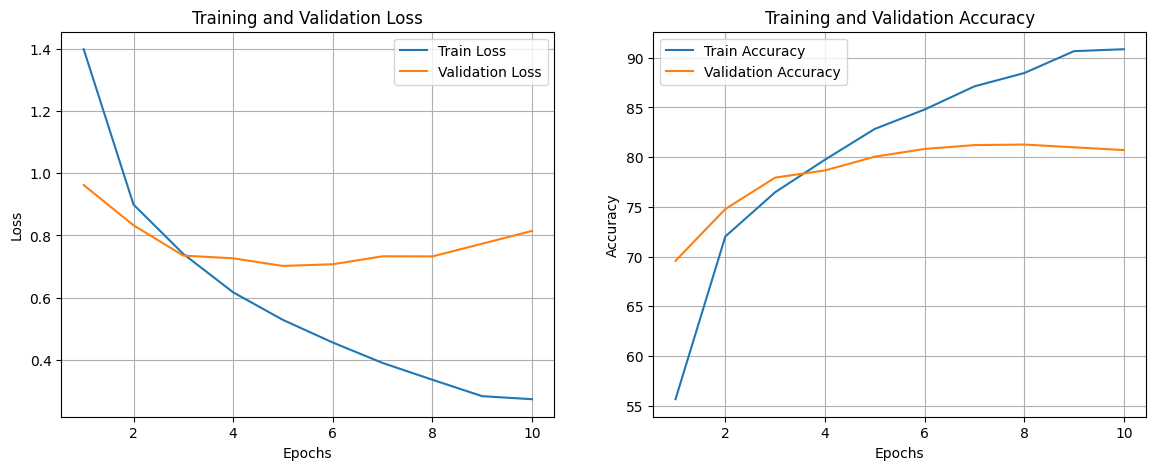

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load train and test datasets
train_data = pd.read_csv('/content/drive/MyDrive/Labelling/balanced_train_dataset.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Labelling/balanced_test_dataset.csv')

# Encode labels
label_encoder = LabelEncoder()
train_data['sub_category'] = label_encoder.fit_transform(train_data['sub_category'])
test_data['sub_category'] = label_encoder.transform(test_data['sub_category'])

# Image loading function
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image from URL {url}: {e}")
        return Image.new('RGB', (64, 64))  # Return a smaller blank image on error

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_url = self.data.iloc[idx]['image']
        img = load_image_from_url(img_url)

        if self.transform:
            img = self.transform(img)

        label = self.data.iloc[idx]['sub_category']
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Define transforms with smaller image size and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = CustomImageDataset(train_data, transform=transform)
test_dataset = CustomImageDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Number of classes
num_classes = len(train_data['sub_category'].unique())

# Instantiate the model
model = CustomCNN(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with best model saving
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')  # Track the lowest validation loss

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        total_samples = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct / total_samples
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct = 0.0, 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct / total_samples
        val_accuracies.append(val_accuracy)

        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/Labelling/best_custom_cnn_model.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Plotting losses and accuracies
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Train the model
train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved best model with validation loss: 1.3496
Epoch [1/10], Train Loss: 1.7767, Train Acc: 39.22%, Val Loss: 1.3496, Val Acc: 57.76%
Saved best model with validation loss: 0.9855
Epoch [2/10], Train Loss: 1.1714, Train Acc: 62.23%, Val Loss: 0.9855, Val Acc: 69.57%
Saved best model with validation loss: 0.9085
Epoch [3/10], Train Loss: 0.9565, Train Acc: 69.55%, Val Loss: 0.9085, Val Acc: 71.62%
Saved best model with validation loss: 0.8137
Epoch [4/10], Train Loss: 0.7930, Train Acc: 75.00%, Val Loss: 0.8137, Val Acc: 76.11%
Saved best model with validation loss: 0.7193
Epoch [5/10], Train Loss: 0.6760, Train Acc: 78.28%, Val Loss: 0.7193, Val Acc: 78.10%
Error loading image from URL https://m.media-amazon.com/images/I/617zSs7i67L._AC_UL320_.jpg: HTTPSConnectionPool(host='m.media-amazon.com', port=443): Max retries exceeded with url: /images/I/617zSs7i67L._AC_UL320_.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7b885f605330>, 'Connection to m.media

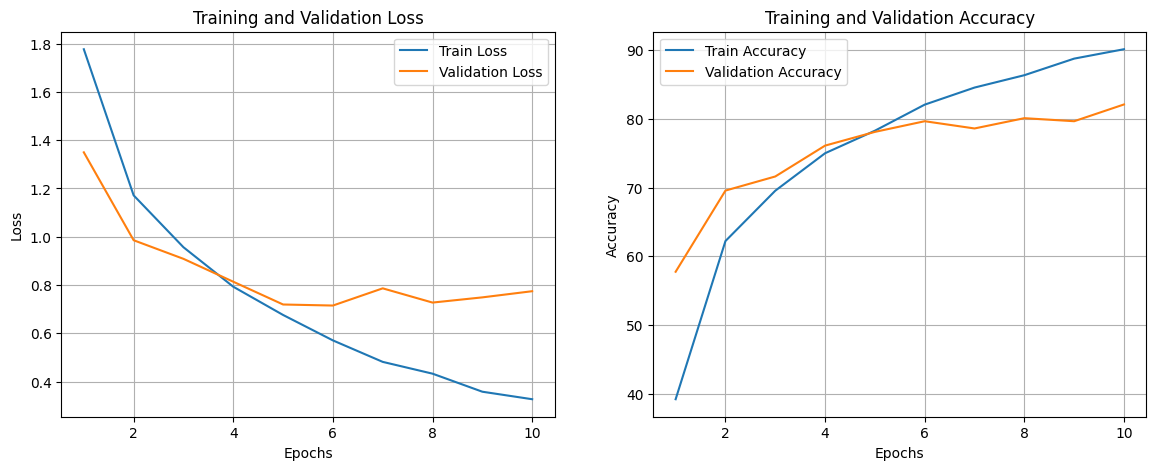

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load train and test datasets
train_data = pd.read_csv('/content/drive/MyDrive/Labelling/balanced_train_dataset.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Labelling/balanced_test_dataset.csv')

# Encode labels
label_encoder = LabelEncoder()
train_data['sub_category'] = label_encoder.fit_transform(train_data['sub_category'])
test_data['sub_category'] = label_encoder.transform(test_data['sub_category'])

# Image loading function
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image from URL {url}: {e}")
        return Image.new('RGB', (64, 64))  # Return a smaller blank image on error

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_url = self.data.iloc[idx]['image']
        img = load_image_from_url(img_url)

        if self.transform:
            img = self.transform(img)

        label = self.data.iloc[idx]['sub_category']
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Define transforms with appropriate image size and normalization for VGG
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # VGG normalization
])

# Load datasets
train_dataset = CustomImageDataset(train_data, transform=transform)
test_dataset = CustomImageDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load VGG16 model
num_classes = len(train_data['sub_category'].unique())
model = models.vgg16(pretrained=True)  # Load pre-trained VGG16
model.classifier[6] = nn.Linear(4096, num_classes)  # Replace the last layer for our number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with best model saving
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')  # Track the lowest validation loss

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        total_samples = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct / total_samples
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct = 0.0, 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct / total_samples
        val_accuracies.append(val_accuracy)

        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/Labelling/best_vgg_model.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Plotting losses and accuracies
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Train the model
train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10)

In [2]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 14.4 MB/s eta 0:00:00


In [3]:
!pip install pytesseract

In [4]:
!apt-get update
!apt-get install -y tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Ign:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,071 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
G

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom CNN Model Definition
class CustomCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load pretrained model with safe loading to handle any mismatched shapes
def load_model(model_path, num_classes):
    model = CustomCNN(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))

    # Filter out mismatched keys in the state_dict to prevent loading errors
    model_state_dict = model.state_dict()
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and v.size() == model_state_dict[k].size()}

    model_state_dict.update(filtered_state_dict)
    model.load_state_dict(model_state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Advanced Color Extraction with Enhanced Descriptors
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Enhanced Shape Detection with Refined Contour Analysis
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Improved Brand Extraction using EasyOCR with Refinement
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        # Refine detected text by filtering for common brand patterns
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()  # Capitalize for a cleaner brand output
    return "Unbranded"

# Dynamic, Detailed Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Path to model and image
model_path = '/content/drive/MyDrive/Labelling/best_custom_cnn_model.pth'
num_classes = 11

# Load model
model = load_model(model_path, num_classes)

# Run analysis and generate description
analyze_image('/content/123.webp', model, label_mapping)

<ipython-input-20-026a232081a6>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteLabel: Refrigerator
Colors: ['gray', 'white']
Shapes: ['triangular', 'rectangular', 'irregular']
Brand: Unbranded
Description: An eye-catching refrigerator with gray, white colors, a triangular, rectangular, irregular style, and .


In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom CNN Model Definition
class CustomCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load pretrained model with safe loading to handle any mismatched shapes
def load_model(model_path, num_classes):
    model = CustomCNN(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))

    # Filter out mismatched keys in the state_dict to prevent loading errors
    model_state_dict = model.state_dict()
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and v.size() == model_state_dict[k].size()}

    model_state_dict.update(filtered_state_dict)
    model.load_state_dict(model_state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Advanced Color Extraction with Enhanced Descriptors
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Enhanced Shape Detection with Refined Contour Analysis
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Improved Brand Extraction using EasyOCR with Refinement
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        # Refine detected text by filtering for common brand patterns
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()  # Capitalize for a cleaner brand output
    return "Unbranded"

# Dynamic, Detailed Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Path to model and image
model_path = '/content/drive/MyDrive/Labelling/best_vgg_model.pth'
num_classes = 11

# Load model
model = load_model(model_path, num_classes)

# Run analysis and generate description
analyze_image('/content/123.webp', model, label_mapping)

<ipython-input-21-56bf27931c6b>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


Label: Refrigerator
Colors: ['gray', 'white']
Shapes: ['triangular', 'rectangular', 'irregular']
Brand: Unbranded
Description: An eye-catching refrigerator with gray, white colors, a triangular, rectangular, irregular style, and .
